In [1]:
import pandas as pd

In [2]:
df1 = pd.read_csv("data/movies.csv")
display(df1.head())
display(df1.info())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


None

In [3]:
df1['movieId'].nunique()

9742

In [4]:
df2 = pd.read_csv("data/links.csv")
display(df2.head())
display(df2.info())

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


None

In [5]:
df2['movieId'].nunique()

9742

Don't need links.csv because it is just an id from imdb, tmdb and movieId is consistent across all 

In [6]:
df3 = pd.read_csv("data/ratings.csv")
display(df3.head())
display(df3.info())

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


None

In [7]:
df3['movieId'].nunique()

9724

In [8]:
df4 = pd.read_csv("data/tags.csv")
display(df4.head())
display(df4.info())

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


None

In [9]:
df4['movieId'].nunique()

1572

In [10]:
df4['tag'].value_counts()

In Netflix queue          131
atmospheric                36
superhero                  24
thought-provoking          24
Disney                     23
                         ... 
Toto                        1
stupid but funny            1
Palme d'Or                  1
long takes                  1
James Fennimore Cooper      1
Name: tag, Length: 1589, dtype: int64

In [11]:
movie = df1.merge(df3,on='movieId')

In [12]:
movie.loc[movie['title'] == "Ready Player One"]

,movieId,title,genres,userId,rating,timestamp
99325,140956,Ready Player One,Action|Sci-Fi|Thriller,209,3.5,1524522239
99326,140956,Ready Player One,Action|Sci-Fi|Thriller,305,4.5,1533043577
99327,140956,Ready Player One,Action|Sci-Fi|Thriller,380,3.0,1534176158
99328,140956,Ready Player One,Action|Sci-Fi|Thriller,514,3.0,1533946119


In [13]:
movie.tail()

,movieId,title,genres,userId,rating,timestamp
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021
100835,193609,Andrew Dice Clay: Dice Rules (1991),Comedy,331,4.0,1537157606


In [14]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   movieId    100836 non-null  int64  
 1   title      100836 non-null  object 
 2   genres     100836 non-null  object 
 3   userId     100836 non-null  int64  
 4   rating     100836 non-null  float64
 5   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 5.4+ MB


In [15]:
movie['movieId'].nunique()

9724

Find a way to merge tags with nulls 

In [16]:
movie['year'] = movie.title.str.split(" ").str.get(-1)

In [17]:
movie.head()

,movieId,title,genres,userId,rating,timestamp,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,(1995)
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,(1995)
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,(1995)
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,(1995)
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,(1995)


In [18]:
movie['title'] = movie.title.str.rsplit(' ',1).str[0]

In [19]:
movie.head()

,movieId,title,genres,userId,rating,timestamp,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,(1995)
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,(1995)
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,(1995)
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,(1995)
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,(1995)


In [20]:
movie['year'] = movie['year'].str.replace(r'[()]',"")

In [21]:
movie.head()

,movieId,title,genres,userId,rating,timestamp,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,1995


In [22]:
movie['year'].value_counts()

1995         6143
1994         5296
1999         4535
1996         4509
2000         4268
             ... 
Watson          1
2006–2007       1
Moonlight       1
Mirror          1
Baby            1
Name: year, Length: 120, dtype: int64

In [23]:
movie.loc[movie['year'] == "Baby"]

,movieId,title,genres,userId,rating,timestamp,year
100428,171631,Maria Bamford: Old,(no genres listed),111,1.0,1517440909,Baby


In [24]:
movie['year'].unique()

array(['1995', '1994', '1996', '1976', '1992', '1967', '1993', '1964',
       '1977', '1965', '1982', '1990', '1991', '1989', '1937', '1940',
       '1969', '1981', '1973', '1970', '1955', '1959', '1968', '1988',
       '1997', '1972', '1943', '1952', '1951', '1957', '1961', '1958',
       '1954', '1934', '1944', '1960', '1963', '1942', '1941', '1953',
       '1939', '1950', '1946', '1945', '1938', '1947', '1935', '1936',
       '1956', '1949', '1932', '1975', '1974', '1971', '1979', '1987',
       '1986', '1980', '1978', '1985', '1966', '1962', '1983', '1984',
       '1948', '1933', '1931', '1922', '1998', '1929', '1930', '1927',
       '1928', '1999', '2000', '1926', '1919', '1921', '1925', '1923',
       '2001', '2002', '2003', '1920', '1915', '1924', '2004', '1916',
       '1917', '', '2005', '2006', '1902', '5', '1903', '2007', '2008',
       '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
       '2017', '2018', '1908', 'One', 'Road', 'Watson', 'Animals',
       'P

In [25]:
movie.loc[movie['year'] == 'One']

,movieId,title,genres,userId,rating,timestamp,year
99325,140956,Ready Player,Action|Sci-Fi|Thriller,209,3.5,1524522239,One
99326,140956,Ready Player,Action|Sci-Fi|Thriller,305,4.5,1533043577,One
99327,140956,Ready Player,Action|Sci-Fi|Thriller,380,3.0,1534176158,One
99328,140956,Ready Player,Action|Sci-Fi|Thriller,514,3.0,1533946119,One


In [26]:
movie.loc[movie['year'] == '']

,movieId,title,genres,userId,rating,timestamp,year
78314,27008,From Dusk Till Dawn 2: Texas Blood Money (1999),Comedy|Crime|Horror,599,1.0,1519333508,
86860,58404,Justice League: The New Frontier (2008),Action|Adventure|Animation|Fantasy|Sci-Fi,380,3.0,1495475893,
86861,58404,Justice League: The New Frontier (2008),Action|Adventure|Animation|Fantasy|Sci-Fi,599,2.5,1498517213,
87046,58842,Assembly (Ji jie hao) (2007),Action|Drama|War,339,4.5,1494291470,
94340,94494,96 Minutes (2011),Drama|Thriller,448,2.5,1397303036,
94461,95004,Superman/Doomsday (2007),Action|Animation,380,4.0,1495476116,
94521,95193,Pocahontas II: Journey to a New World (1998),Adventure|Animation|Children,509,2.0,1436000518,
94786,96608,Runaway Brain (1995),Animation|Comedy|Sci-Fi,89,5.0,1520409497,
95536,102084,Justice League: Doom (2012),Action|Animation|Fantasy,380,5.0,1493421861,
95943,104017,3 dev adam (Three Giant Men) (1973),Action|Adventure|Sci-Fi,599,0.5,1519369145,


In [27]:
movie['flag'] = movie.apply(lambda k: 1 if(k['year']=='') else
                           1 if(k['year']=='5') else
                           1 if(k['year']=='One') else
                           1 if(k['year']=='Road') else
                           1 if(k['year']=='Watson') else
                           1 if(k['year']=='Animals') else
                           1 if(k['year']=='Paterson') else
                           1 if(k['year']=='Moonlight') else
                           1 if(k['year']=='OA') else
                           1 if(k['year']=='Cosmos') else
                           1 if(k['year']=='Baby') else
                           1 if(k['year']=='2006-2007') else
                           1 if(k['year']=='2') else
                           1 if(k['year']=='Mirror') else
                           0
                           , axis=1)

In [28]:
movie = movie[movie['flag']!=1]
movie = movie.drop ('flag', axis=1)
movie

,movieId,title,genres,userId,rating,timestamp,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,1995
...,...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,184,4.0,1537109082,2017
100832,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,184,3.5,1537109545,2017
100833,193585,Flint,Drama,184,3.5,1537109805,2017
100834,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,184,3.5,1537110021,2018


In [29]:
movie['year'].value_counts()

1995         6143
1994         5296
1999         4535
1996         4509
2000         4268
             ... 
1915            1
1919            1
1908            1
1917            1
2006–2007       1
Name: year, Length: 107, dtype: int64

In [30]:
movie.loc[movie['year'] == '2006–2007', 'year'] = '2008'

In [31]:
movie['year'].value_counts()

1995    6143
1994    5296
1999    4535
1996    4509
2000    4268
        ... 
1903       2
1915       1
1919       1
1908       1
1917       1
Name: year, Length: 106, dtype: int64

In [32]:
movie.loc[movie['year'] == '1995']

,movieId,title,genres,userId,rating,timestamp,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,1995
...,...,...,...,...,...,...,...
95334,99130,Ice Cream Man,Comedy|Horror,89,3.5,1520409565,1995
98718,132084,Let It Be Me,(no genres listed),599,2.5,1519142705,1995
99071,136297,Mortal Kombat: The Journey Begins,Action|Animation,599,0.5,1519175186,1995
100280,167772,The Spirit of Christmas,Animation|Comedy,89,1.5,1520408904,1995


In [33]:
movie.loc[movie['genres'] == '(no genres listed)', 'genres'] = 'Unknown'

In [34]:
movie['genres'].value_counts()

Comedy                                  7196
Drama                                   6290
Comedy|Romance                          3967
Comedy|Drama|Romance                    3000
Comedy|Drama                            2851
                                        ... 
Drama|Film-Noir|Mystery|Thriller           1
Adventure|Documentary|IMAX                 1
Comedy|Crime|Horror|Mystery|Thriller       1
Animation|Comedy|Drama|Romance             1
Animation|Drama|Sci-Fi                     1
Name: genres, Length: 951, dtype: int64

In [35]:
movie.head()

,movieId,title,genres,userId,rating,timestamp,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,1995


In [36]:
dummies = movie['genres'].str.get_dummies(sep='|')
movie = pd.concat([movie, dummies], axis=1)
movie.head()

,movieId,title,genres,userId,rating,timestamp,year,Action,Adventure,Animation,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,Unknown,War,Western
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [37]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100806 entries, 0 to 100835
Data columns (total 27 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   movieId      100806 non-null  int64  
 1   title        100806 non-null  object 
 2   genres       100806 non-null  object 
 3   userId       100806 non-null  int64  
 4   rating       100806 non-null  float64
 5   timestamp    100806 non-null  int64  
 6   year         100806 non-null  object 
 7   Action       100806 non-null  int64  
 8   Adventure    100806 non-null  int64  
 9   Animation    100806 non-null  int64  
 10  Children     100806 non-null  int64  
 11  Comedy       100806 non-null  int64  
 12  Crime        100806 non-null  int64  
 13  Documentary  100806 non-null  int64  
 14  Drama        100806 non-null  int64  
 15  Fantasy      100806 non-null  int64  
 16  Film-Noir    100806 non-null  int64  
 17  Horror       100806 non-null  int64  
 18  IMAX         100806 non-

In [38]:
movie['year'] = movie['year'].astype(int)

In [39]:
movie['year'].dtype

dtype('int64')

In [40]:
movie['rating'].value_counts()

4.0    26814
3.0    20042
5.0    13205
3.5    13133
4.5     8547
2.0     7549
2.5     5548
1.0     2809
1.5     1791
0.5     1368
Name: rating, dtype: int64

In [41]:
movie['timestamp'].nunique()

85014

In [42]:
#pip install wordcloud

In [43]:
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt

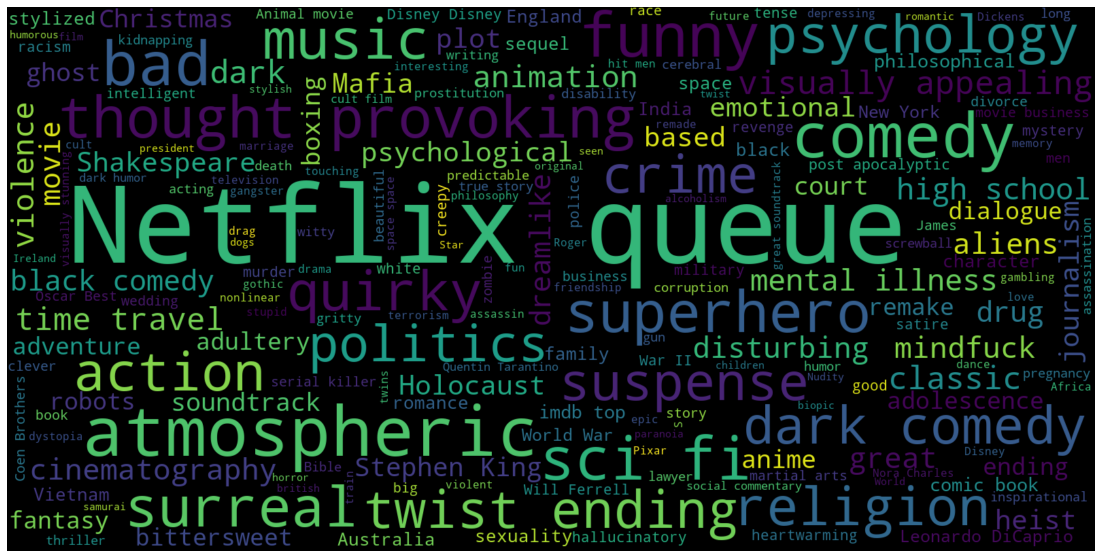

In [44]:
tag = " ".join(i for i in df4.tag)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width=1600, height=800, stopwords=stopwords).generate(tag)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## EDA

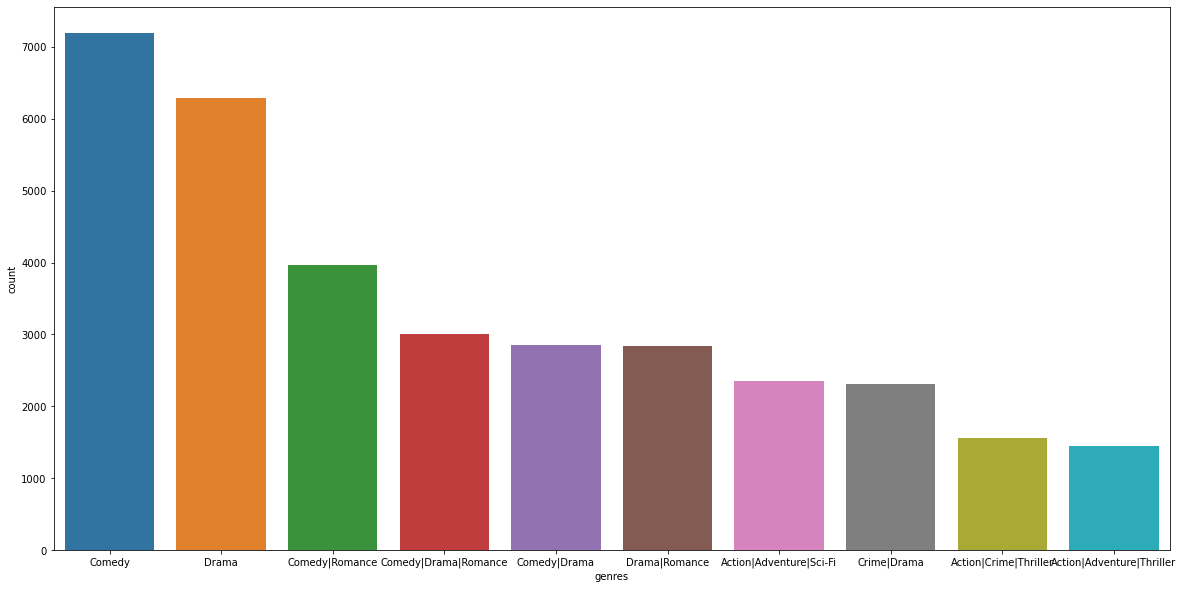

In [45]:
import seaborn as sns
genre_df = movie[['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
                 'Unknown']]


plt.figure(figsize=(20,10))
sns.countplot(x=movie['genres'], order=movie.genres.value_counts().iloc[:10].index);
    

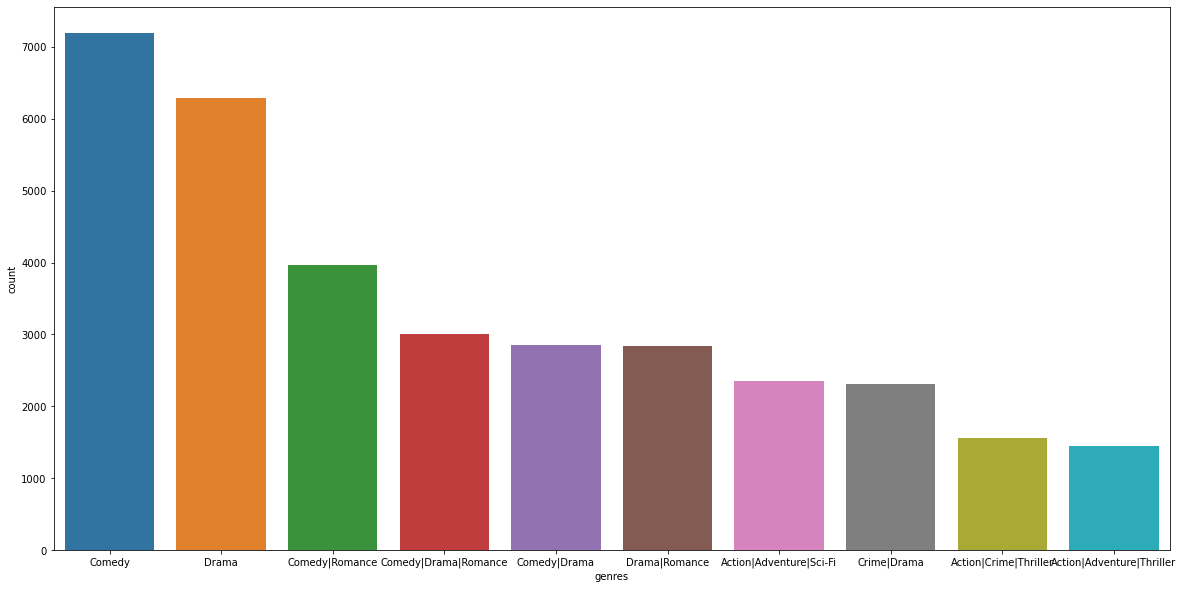

In [46]:
plt.figure(figsize=(20,10))
sns.countplot(data = genre_df, x=movie['genres'], order=movie.genres.value_counts().iloc[:10].index);

In [47]:
#genre_df.value_counts().sort_values().plot(kind = 'barh')

In [48]:
genre_df['Action'].value_counts() 

0    70183
1    30623
Name: Action, dtype: int64

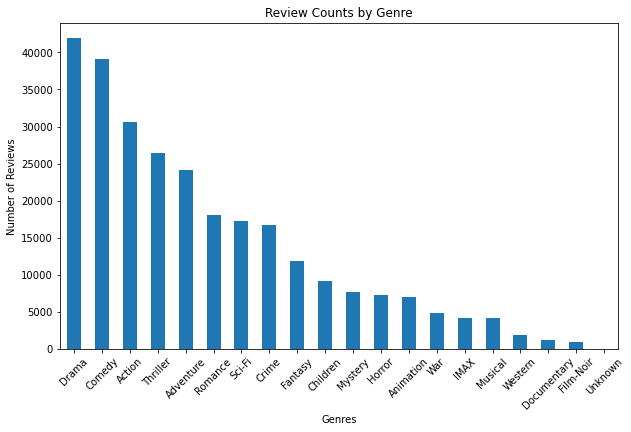

In [49]:
genre_df.sum().sort_values(ascending=False).plot(kind='bar', figsize=(10,6), title='Review Counts by Genre', xlabel='Genres',
                                                ylabel='Number of Reviews', rot=45);

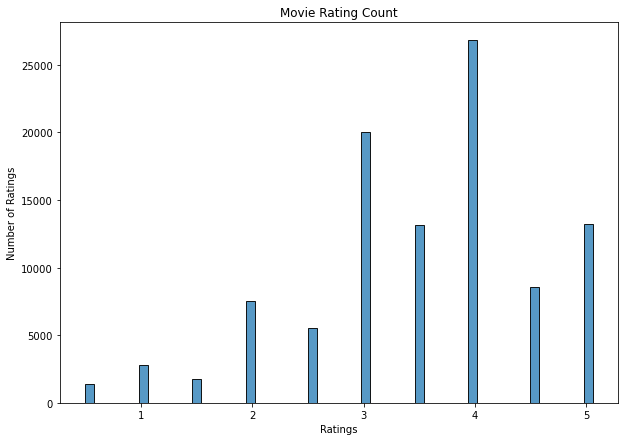

In [50]:
#ratings count
plt.figure(figsize=(10,7))
sns.histplot(data=movie, x='rating', binwidth=.08)
plt.ylabel("Number of Ratings")
plt.xlabel("Ratings")
plt.title('Movie Rating Count');

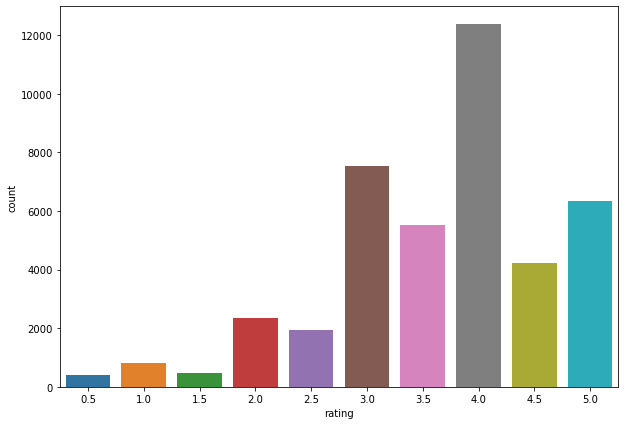

In [51]:
#genres and ratings
drama = movie.loc[movie['Drama'] == 1]
drama['Drama'].value_counts()

plt.figure(figsize=(10,7))
sns.countplot(data=drama, x='rating');

In [52]:
#comedy['Comedy'].value_counts()

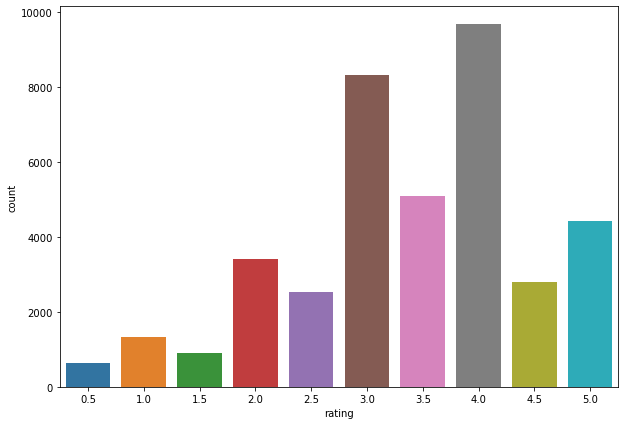

In [53]:
comedy = movie.loc[movie['Comedy'] == 1]
comedy['Comedy'].value_counts()

plt.figure(figsize=(10,7))
sns.countplot(data=comedy, x='rating');

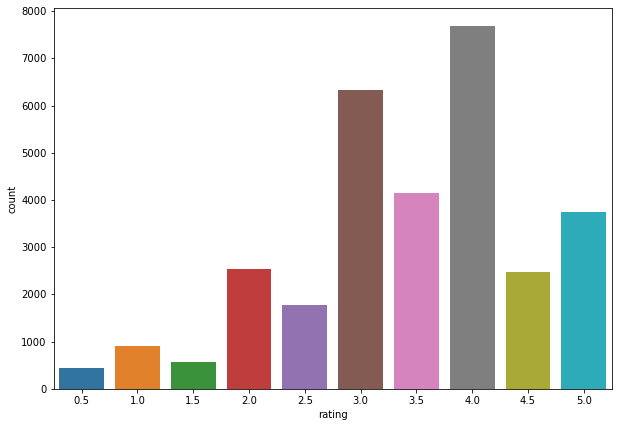

In [54]:
action = movie.loc[movie['Action'] == 1]
action['Action'].value_counts()

plt.figure(figsize=(10,7))
sns.countplot(data=action, x='rating');

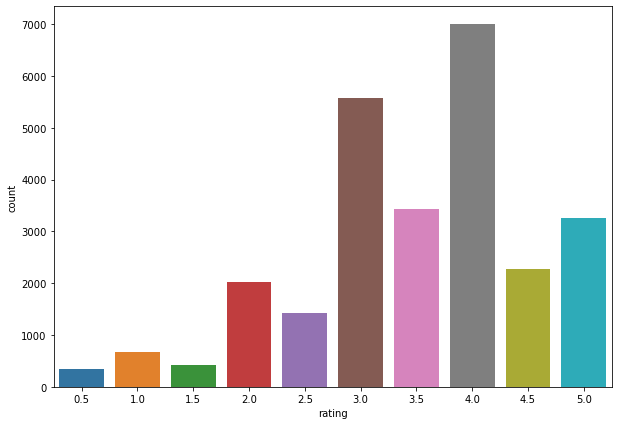

In [55]:
thriller = movie.loc[movie['Thriller'] == 1]
thriller['Thriller'].value_counts()

plt.figure(figsize=(10,7))
sns.countplot(data=thriller, x='rating');

In [56]:
thriller['Thriller'].value_counts()

1    26446
Name: Thriller, dtype: int64

In [57]:
movie.loc[movie['userId'] == 414].head(10)

,movieId,title,genres,userId,rating,timestamp,year,Action,Adventure,Animation,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,Unknown,War,Western
146,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,414,4.0,961438127,1995,0,1,1,...,0,0,0,0,0,0,0,0,0,0
281,2,Jumanji,Adventure|Children|Fantasy,414,3.0,961594981,1995,0,1,0,...,0,0,0,0,0,0,0,0,0,0
361,3,Grumpier Old Men,Comedy|Romance,414,4.0,961439278,1995,0,0,0,...,0,0,0,0,1,0,0,0,0,0
414,5,Father of the Bride Part II,Comedy,414,2.0,961437647,1995,0,0,0,...,0,0,0,0,0,0,0,0,0,0
502,6,Heat,Action|Crime|Thriller,414,3.0,961515642,1995,1,0,0,...,0,0,0,0,0,0,1,0,0,0
571,7,Sabrina,Comedy|Romance,414,3.0,961439170,1995,0,0,0,...,0,0,0,0,1,0,0,0,0,0
594,8,Tom and Huck,Adventure|Children,414,3.0,961594849,1995,0,1,0,...,0,0,0,0,0,0,0,0,0,0
699,10,GoldenEye,Action|Adventure|Thriller,414,3.0,961515863,1995,1,1,0,...,0,0,0,0,0,0,1,0,0,0
791,11,"American President, The",Comedy|Drama|Romance,414,5.0,1052148205,1995,0,0,0,...,0,0,0,0,1,0,0,0,0,0
866,15,Cutthroat Island,Action|Adventure|Romance,414,2.0,961514611,1995,1,1,0,...,0,0,0,0,1,0,0,0,0,0


In [58]:
movie.loc[movie['userId'] == 414].tail(10)

,movieId,title,genres,userId,rating,timestamp,year,Action,Adventure,Animation,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,Unknown,War,Western
100618,177615,Lady Bird,Comedy,414,4.5,1521844149,2017,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100638,178061,"I, Tonya",Drama,414,4.0,1521844167,2017,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100668,179817,Darkest Hour,Drama|War,414,4.0,1525562730,2017,0,0,0,...,0,0,0,0,0,0,0,0,1,0
100676,179819,Star Wars: The Last Jedi,Action|Adventure|Fantasy|Sci-Fi,414,4.5,1513958832,2017,1,1,0,...,0,0,0,0,0,1,0,0,0,0
100688,180031,The Shape of Water,Adventure|Drama|Fantasy,414,4.0,1519592584,2017,0,1,0,...,0,0,0,0,0,0,0,0,0,0
100691,180045,Molly's Game,Drama,414,4.0,1515207301,2017,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100701,180497,The Post,Drama|Thriller,414,4.0,1525548614,2017,0,0,0,...,0,0,0,0,0,0,1,0,0,0
100705,180985,The Greatest Showman,Drama,414,3.5,1527978072,2017,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100762,184791,Fred Armisen: Standup for Drummers,Comedy,414,2.5,1519592410,2018,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100799,187595,Solo: A Star Wars Story,Action|Adventure|Children|Sci-Fi,414,3.5,1527977920,2018,1,1,0,...,0,0,0,0,0,1,0,0,0,0


In [59]:
df4.loc[df4['userId'] == 414].head()

,userId,movieId,tag,timestamp


In [60]:
super_users = list(movie['userId'].value_counts().iloc[:10].index)
super_users_count = list(movie['userId'].value_counts().iloc[:10].values)

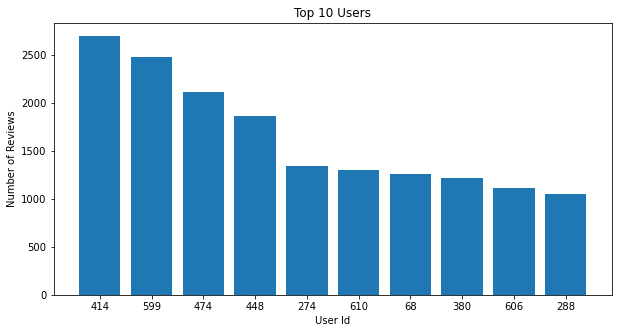

In [61]:
#plotting users
import numpy as np
fig, ax= plt.subplots(figsize=(10, 5))

ax.set_xlabel("User Id")
ax.set_ylabel("Number of Reviews")
ax.set_title("Top 10 Users")

x_pos = np.arange(len(super_users))
plt.bar(x_pos, super_users_count)
plt.xticks(x_pos, super_users)

plt.show();

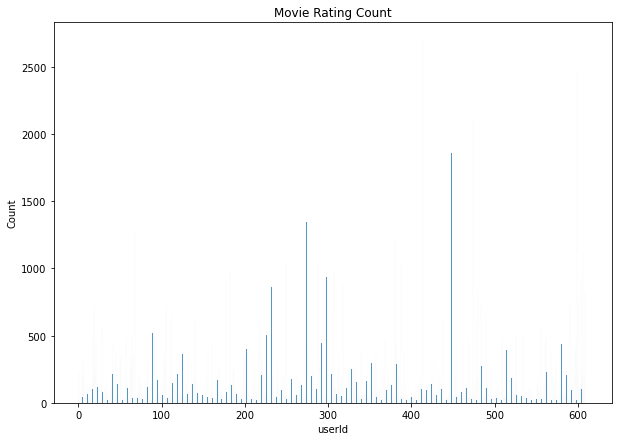

In [62]:
#userId count
plt.figure(figsize=(10,7))
sns.histplot(data=movie, x='userId', binwidth=.2)
plt.title('Movie Rating Count');

In [63]:
#average rating and genre
genre_ratings_df = movie[['rating', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
                 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western',
                 'Unknown']]


genre_ratings_df

,rating,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,Unknown
0,4.0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,4.0,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,4.5,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,2.5,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4.5,0,1,1,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,4.0,1,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
100832,3.5,0,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
100833,3.5,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
100834,3.5,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
rating_genres = genre_df.sum()
rating_genres

Action         30623
Adventure      24157
Animation       6982
Children        9207
Comedy         39049
Crime          16679
Documentary     1219
Drama          41923
Fantasy        11831
Film-Noir        870
Horror          7287
IMAX            4145
Musical         4138
Mystery         7674
Romance        18124
Sci-Fi         17233
Thriller       26446
War             4858
Western         1930
Unknown           38
dtype: int64

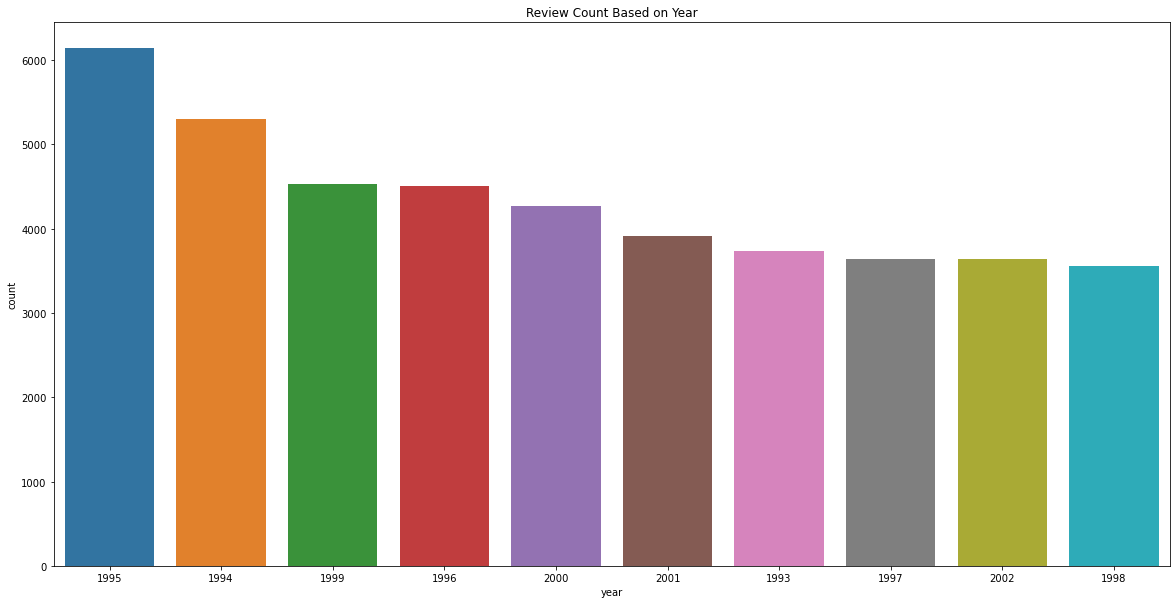

In [65]:
# Top 10 Review Count Based on Year
plt.figure(figsize=(20,10))
sns.countplot(data=movie, x='year', order=movie.year.value_counts().iloc[:10].index)
plt.title('Review Count Based on Year');

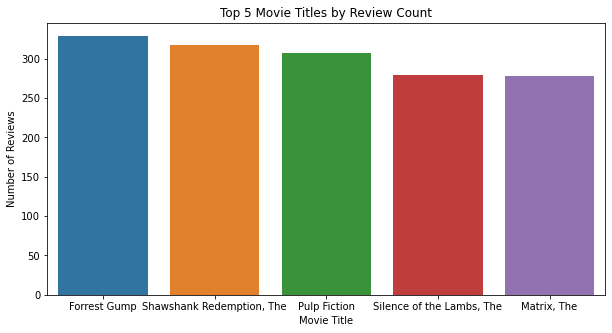

In [66]:
#top 5 movie titles 

plt.figure(figsize=(10,5))
sns.countplot(data=movie, x='title', order=movie.title.value_counts().iloc[:5].index)
plt.ylabel("Number of Reviews")
plt.xlabel("Movie Title")
plt.title("Top 5 Movie Titles by Review Count");

## Data Preprocessing

In [67]:
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
import numpy as np
from surprise import Dataset, Reader, BaselineOnly
from surprise import accuracy

In [68]:
reader = Reader(rating_scale=(0.5, 5))

movie_surprise = Dataset.load_from_df(movie[['movieId', 'userId', 'rating']], reader)

In [69]:
#train-test split 
from surprise.model_selection.split import train_test_split

train, test = train_test_split(movie_surprise, test_size=0.2, random_state=42)

In [70]:
print('Number of users: ', train.n_users, '\n')
print('Number of items: ', train.n_items, '\n')

Number of users:  8959 

Number of items:  610 



# Memory-Based Methods
## cosine similarity 

In [71]:
#item to item similarity 
sim_cos = {'name':'cosine', 'user_based':False}

In [72]:
basic = KNNBasic(sim_options=sim_cos)
basic.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [73]:
#
predictions = basic.test(test)
print(accuracy.rmse(predictions))

RMSE: 0.9672
0.9671630935763456


In [74]:
#user to user
sim_cos_user = {'name':'cosine', 'user_based':True}

basic_user = KNNBasic(sim_options=sim_cos_user)
basic_user.fit(train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [75]:
#this is worse because want lower RMSE
predictions_user = basic_user.test(test)
print(accuracy.rmse(predictions_user))

RMSE: 0.9720
0.9720337803647293


In [76]:
sim_cos_baseline = {'name':'cosine', 'user_based':False}
knn_baseline_cos = KNNBaseline(sim_options=sim_cos_baseline)
knn_baseline_cos.fit(train)
predictions_baseline_cos = knn_baseline_cos.test(test)
print(accuracy.rmse(predictions_baseline_cos))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8778
0.8777684214621624


In [77]:
#user-based similarity KNNBaseline
sim_cos_baseline_u = {'name':'cosine', 'user_based':True}
knn_baseline_cos_u = KNNBaseline(sim_options=sim_cos_baseline_u)
knn_baseline_cos_u.fit(train)
predictions_baseline_cos_u = knn_baseline_cos_u.test(test)
print(accuracy.rmse(predictions_baseline_cos_u))

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8923
0.8923143388850235


## pearson similarity

In [78]:
#item-based
sim_pearson = {'name':'pearson', 'user_based':False}
knn_basic = KNNBasic(sim_options=sim_pearson)
knn_basic.fit(train)
predictions_basic = knn_basic.test(test)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9672
0.9671630935763456


In [79]:
#item-based
sim_pearson_means = {'name':'pearson', 'user_based':False}
knn_means = KNNWithMeans(sim_options=sim_pearson_means)
knn_means.fit(train)
predictions_means = knn_means.test(test)
print(accuracy.rmse(predictions_means))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8965
0.8965328187984525


In [80]:
#item-based
sim_pearson_baseline = {'name':'pearson', 'user_based':False}
knn_baseline = KNNBaseline(sim_options=sim_pearson_baseline)
knn_baseline.fit(train)
predictions_baseline = knn_baseline.test(test)
print(accuracy.rmse(predictions_baseline))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8766
0.8765853912880508


In [81]:
#user-based
sim_pearson_baseline_u = {'name':'pearson', 'user_based':True}
knn_baseline_u = KNNBaseline(sim_options=sim_pearson_baseline_u)
knn_baseline_u.fit(train)
predictions_baseline_u = knn_baseline_u.test(test)
print(accuracy.rmse(predictions_baseline_u))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8843
0.8842882968145761


KNNBaseline performs the best in terms of cosine and pearson similarity in item based simlarity:
- cosine accuracy score: 87.77684214621624
- pearson accuracy score: 87.65853912880508

# Model-Based Methods


In [82]:
#GridSearch SVD 
#param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
#              'reg_all': [0.4, 0.6]}
#gs_model = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1,joblib_verbose=5)
#gs_model.fit(movie_surprise)

In [84]:
#print(gs_model.best_score["rmse"])
#print(gs_model.best_params["rmse"])

In [90]:
from surprise.prediction_algorithms.matrix_factorization import SVDpp, NMF
from surprise.prediction_algorithms.slope_one import SlopeOne
from surprise.prediction_algorithms.random_pred import NormalPredictor
from surprise.prediction_algorithms import KNNWithZScore
from surprise.prediction_algorithms.baseline_only import BaselineOnly
from surprise.prediction_algorithms.co_clustering import CoClustering

In [93]:
#benchmark = []
# Iterate over all algorithms
#for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
    # Perform cross validation
    #results = cross_validate(algorithm, movie_surprise, measures=['RMSE'], cv=3, verbose=False)
    
    # Get results & append algorithm name
    #tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    #tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    #benchmark.append(tmp)
    
#pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse') 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.852266,46.203633,1.822581
KNNBaseline,0.871035,3.976595,11.664182
BaselineOnly,0.880884,0.118499,0.132768
SVD,0.884401,5.157042,0.348105
SlopeOne,0.896544,0.218652,1.328547
KNNWithMeans,0.900399,4.050330,10.915179
KNNWithZScore,0.907425,4.270243,11.616178
KNNBasic,0.913157,3.801452,10.279274
NMF,0.932241,4.970665,0.263186


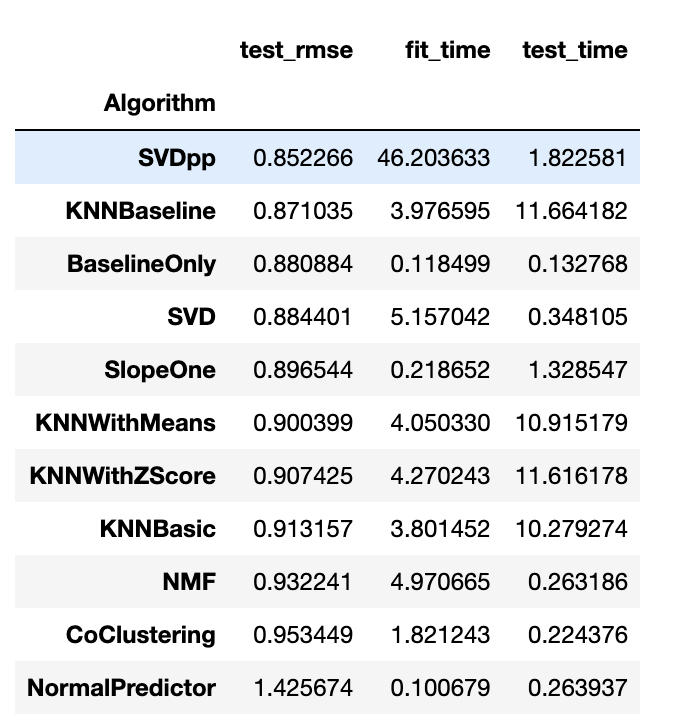

In [95]:
#final model 
model = SVDpp(random_state=42)
results = cross_validate(model, movie_surprise, measures=['RMSE'], cv=3, verbose=False)
results

{'test_rmse': array([0.85249979, 0.85413022, 0.85208747]),
 'fit_time': (45.756016969680786, 47.307730197906494, 47.641016721725464),
 'test_time': (1.9096949100494385, 2.6240041255950928, 1.916395902633667)}

In [101]:
model.fit(train)
model.predict(10, 30)

Prediction(uid=10, iid=30, r_ui=None, est=4.150279264736992, details={'was_impossible': False})

In [105]:
movie.loc[(movie['movieId'] == 30)]

,movieId,title,genres,userId,rating,timestamp,year,Action,Adventure,Animation,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,Unknown,War,Western
1461,30,Shanghai Triad (Yao a yao yao dao waipo qiao),Crime|Drama,325,4.0,1039399501,1995,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1462,30,Shanghai Triad (Yao a yao yao dao waipo qiao),Crime|Drama,527,1.0,1033173581,1995,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1463,30,Shanghai Triad (Yao a yao yao dao waipo qiao),Crime|Drama,603,4.0,963179273,1995,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
user_10 = movie.loc[(movie['userId'] == 10)]
user_10.head()

,movieId,title,genres,userId,rating,timestamp,year,Action,Adventure,Animation,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,Unknown,War,Western
7865,296,Pulp Fiction,Comedy|Crime|Drama|Thriller,10,1.0,1455303387,1994,0,0,0,...,0,0,0,0,0,0,1,0,0,0
10023,356,Forrest Gump,Comedy|Drama|Romance|War,10,3.5,1455301685,1994,0,0,0,...,0,0,0,0,1,0,0,0,1,0
15472,588,Aladdin,Adventure|Animation|Children|Comedy|Musical,10,4.0,1455306173,1992,0,1,1,...,0,0,1,0,0,0,0,0,0,0
16793,597,Pretty Woman,Comedy|Romance,10,3.5,1455357645,1990,0,0,0,...,0,0,0,0,1,0,0,0,0,0
20584,912,Casablanca,Drama|Romance,10,4.0,1455302254,1942,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [109]:
user_10['title'].unique()

array(['Pulp Fiction', 'Forrest Gump', 'Aladdin', 'Pretty Woman',
       'Casablanca', 'Mary Poppins', 'Dirty Dancing', 'Graduate, The',
       'When Harry Met Sally...', 'As Good as It Gets', 'Mulan',
       'Matrix, The', 'Notting Hill', 'Sixth Sense, The',
       'American Beauty', 'Fight Club', 'Gladiator', 'Bring It On',
       "Bridget Jones's Diary", 'Shrek', 'Legally Blonde',
       'Lord of the Rings: The Fellowship of the Ring, The',
       'Beautiful Mind, A', 'Walk to Remember, A', 'About a Boy',
       'Sweet Home Alabama', 'Maid in Manhattan',
       'Lord of the Rings: The Two Towers, The', 'Two Weeks Notice',
       'How to Lose a Guy in 10 Days', 'What a Girl Wants',
       'Finding Nemo', 'Legally Blonde 2: Red, White & Blonde',
       'Love Actually', "Something's Gotta Give",
       'Girl with a Pearl Earring',
       'Lord of the Rings: The Return of the King, The',
       'Mona Lisa Smile', 'Chasing Liberty', '50 First Dates',
       'Prince & Me, The', 'Mean Girl

In [100]:
svd = SVD(n_factors= 50, reg_all=0.05)
svd.fit(train)
svd.predict(2, 4)

Prediction(uid=2, iid=4, r_ui=None, est=3.2677189627383085, details={'was_impossible': False})

## User Recommendations

In [125]:
def movie_rater(movie_df, num, genre=None):
    userID = 1000
    rating_list = []
    while num > 0:
        if genre:
            movie = movie_df[movie_df['genres'].str.contains(genre)].sample(1)
        else:
            movie = movie_df.sample(1)
        print(movie)
        rating = input('How do you rate this movie on a scale of 1-5, press n if you have not seen :\n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID, 'movieId':movie['movieId'].values[0],'rating':rating}
            rating_list.append(rating_one_movie) 
            num -= 1
    return rating_list      

In [126]:
rater_df = movie.drop(columns=['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 
                    'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
                    'War', 'Western', 'Unknown', 'timestamp'], axis=1)

In [127]:
user_rating = movie_rater(rater_df, 4, 'Comedy')

      movieId         title  genres  userId  rating  year
6358      234  Exit to Eden  Comedy     136     3.0  1994


KeyboardInterrupt: Interrupted by user

In [128]:
predict_df = rater_df.drop(columns=['title', 'genres', 'year'], axis=1)
predict_df.head()

,movieId,userId,rating
0,1,1,4.0
1,1,5,4.0
2,1,7,4.5
3,1,15,2.5
4,1,17,4.5


In [144]:
user_rating = [{'userId': 1000, 'movieId': 55245, 'rating': '5'},
 {'userId': 1000, 'movieId': 2491, 'rating': '4'},
 {'userId': 1000, 'movieId': 4718, 'rating': '4'},
 {'userId': 1000, 'movieId': 5990, 'rating': '3'}]

## Making Predictions for User 1000

In [145]:
## add the new ratings to the original ratings DataFrame
new_ratings_df = predict_df.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df,reader)

In [146]:
SVDpp_ = SVDpp(random_state=42)
SVDpp_.fit(new_data.build_full_trainset())

In [147]:
list_of_movies = []
for m_id in predict_df['movieId'].unique():
    list_of_movies.append((m_id,SVDpp_.predict(1000,m_id)[3]))

In [148]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [151]:
len(ranked_movies)

9701

In [152]:
# return the top n recommendations using the 
def recommended_movies(user_ratings, movie_title_df, n):
    for idx, rec in enumerate(user_ratings):
        title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n-= 1
        if n == 0:
            break
            
recommended_movies(ranked_movies, df1, 5)

Recommendation #  1 :  48    Lamerica (1994)
Name: title, dtype: object 

Recommendation #  2 :  39    Restoration (1995)
Name: title, dtype: object 

Recommendation #  3 :  143    Jeffrey (1995)
Name: title, dtype: object 

Recommendation #  4 :  393    Widows' Peak (1994)
Name: title, dtype: object 

Recommendation #  5 :  458    Ruby in Paradise (1993)
Name: title, dtype: object 



In [141]:
rater_df.loc[rater_df['title'] == 'Restoration']

,movieId,title,genres,userId,rating,year
2006,43,Restoration,Drama,6,4.0,1995
2007,43,Restoration,Drama,33,2.0,1995
2008,43,Restoration,Drama,288,3.0,1995
2009,43,Restoration,Drama,437,3.0,1995
2010,43,Restoration,Drama,470,3.0,1995
2011,43,Restoration,Drama,474,3.5,1995
2012,43,Restoration,Drama,521,4.0,1995
2013,43,Restoration,Drama,599,3.0,1995
